# Author: Nhlalonhle Tsotetsi

### For: A/Prof Olabisi Falowo

User's Migration Final Year Project Simulation

Run the cells one by one, they all produce results used in the report

------------------------------------------------------------------------------------------------------------------------------------------


##  1. Simulation Setup and Core Definitions

This cell sets up the entire simulation environment.  
It imports all required libraries, defines the data classes (`NetworkGeneration`, `User`, `NetworkEnvironment`, `IncentiveManager`),  
and implements the main `MigrationSimulator` class that handles user initialization, baseline and incentive simulations, and visualization methods.

Run this once at the beginning to define everything needed for the subsequent cells.


In [20]:
# --- Setup: imports, folders, seeds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from typing import Dict, List
from dataclasses import dataclass
import warnings, os

warnings.filterwarnings('ignore')
os.makedirs('simulation_figures', exist_ok=True)

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

# Global reproducibility
np.random.seed(42)
random.seed(42)

GENS = ['2G', '3G', '4G', '5G']
GEN_INDEX = {g: i for i, g in enumerate(GENS)}

#   DATA CLASSES & USERS
@dataclass
class NetworkGeneration:
    generation: str
    data_speed_mbps: float
    latency_ms: float
    coverage_quality: float  # 0–1

    def qos_score(self) -> float:
        smin, smax = 0.1, 100.0
        speed_score = 100 * (np.log10(max(self.data_speed_mbps, smin)) - np.log10(smin)) / (np.log10(smax) - np.log10(smin))
        speed_score = float(np.clip(speed_score, 0, 100))
        lmax = 500.0
        latency_score = 100 * (1 - min(self.latency_ms, lmax) / lmax)
        coverage_score = float(self.coverage_quality) * 100.0
        return (speed_score + latency_score + coverage_score) / 3.0

class User:
    def __init__(self, user_id: int, current_generation: str):
        self.user_id = user_id
        self.current_generation = current_generation
        self.price_sensitivity   = np.random.beta(2, 2) * 0.8 + 0.1
        self.technology_affinity = np.random.beta(2, 5) * 0.9 + 0.1
        self.income_level        = np.clip(np.random.lognormal(0, 0.5), 0.1, 1.0)
        self.switching_cost_sensitivity = np.random.uniform(0.1, 0.9)
        self.network_effect_sensitivity = np.random.uniform(0.1, 0.9)
        self.migration_history = []
        self.months_on_current_gen = np.random.randint(1, 24)

    def calculate_utility(self, target_generation: str, networks: Dict,
                          incentives: Dict, base_costs: Dict) -> float:
        if target_generation == self.current_generation:
            return 0.0
        current_net = networks[self.current_generation]
        target_net  = networks[target_generation]
        qos_improvement = target_net.qos_score() - current_net.qos_score()
        qos_benefit     = self.technology_affinity * qos_improvement
        econ = 0.0
        if 'device_subsidy' in incentives:
            econ += incentives['device_subsidy'].get(target_generation, 0)
        if 'bundle_discount' in incentives:
            econ += incentives['bundle_discount'].get(target_generation, 0)
        if 'loyalty_bonus' in incentives:
            econ += incentives['loyalty_bonus'].get(target_generation, 0)
        economic_incentive = self.price_sensitivity * econ
        base_switch = base_costs.get('switching_once', 300)
        perceived_switch = base_switch * (2 - self.income_level) * (1 - 0.5 * self.technology_affinity)
        switching_penalty = self.switching_cost_sensitivity * perceived_switch / 100.0
        return qos_benefit + economic_incentive - switching_penalty

    def migration_probability(self, target_generation: str, networks: Dict,
                              incentives: Dict, base_costs: Dict) -> float:
        utility = self.calculate_utility(target_generation, networks, incentives, base_costs)
        return float(np.clip(sigmoid(utility / 50.0), 0, 1))

    def make_migration_decision(self, available_generations: List[str],
                                networks: Dict, incentives: Dict, base_costs: Dict) -> str:
        gen_levels = {'2G': 1, '3G': 2, '4G': 3, '5G': 4}
        probs = {}
        for gen in available_generations:
            if gen != self.current_generation and gen_levels[gen] > gen_levels[self.current_generation]:
                probs[gen] = self.migration_probability(gen, networks, incentives, base_costs)
        probs[self.current_generation] = 0.8  # stay bias
        total = sum(probs.values())
        if total == 0:
            return self.current_generation
        probs = {g: p / total for g, p in probs.items()}
        r, acc = random.random(), 0.0
        for g, p in probs.items():
            acc += p
            if r <= acc:
                return g
        return self.current_generation

    def migrate_to(self, new_generation: str, month: int):
        if new_generation != self.current_generation:
            self.migration_history.append({'from': self.current_generation, 'to': new_generation, 'month': month})
            self.current_generation = new_generation
            self.months_on_current_gen = 0
        else:
            self.months_on_current_gen += 1

#   ENVIRONMENT & INCENTIVES
class NetworkEnvironment:
    def __init__(self):
        self.networks = {
            '2G': NetworkGeneration('2G', 0.1, 500, 0.90),
            '3G': NetworkGeneration('3G', 1.0,  100, 0.80),
            '4G': NetworkGeneration('4G', 20.0, 40, 0.60),
            '5G': NetworkGeneration('5G', 100.0, 5, 0.30)
        }
        self.base_costs = {'switching_once': 300, 'plan_change': 100, 'learning_curve': 50}

    def get_available_generations(self) -> List[str]:
        return list(self.networks.keys())

    def get_network_info(self) -> pd.DataFrame:
        rows = []
        for gen, net in self.networks.items():
            rows.append({
                'Generation': gen,
                'Speed (Mbps)': net.data_speed_mbps,
                'Latency (ms)': net.latency_ms,
                'Coverage Quality': net.coverage_quality,
                'QoS Score': round(net.qos_score(), 2)
            })
        return pd.DataFrame(rows)

class IncentiveManager:
    def __init__(self):
        self.active_incentives = {}
    def set_device_subsidies(self, d: Dict[str, float]):   self.active_incentives['device_subsidy'] = d
    def set_bundle_discounts(self, d: Dict[str, float]):   self.active_incentives['bundle_discount'] = d
    def set_loyalty_bonuses(self, d: Dict[str, float]):    self.active_incentives['loyalty_bonus'] = d
    def clear_incentives(self):                            self.active_incentives = {}
    def get_incentive_summary(self) -> Dict:               return self.active_incentives.copy()

#   MIGRATION SIMULATOR
class MigrationSimulator:
    def __init__(self, num_users: int = 100_000):
        self.num_users = num_users
        self.env = NetworkEnvironment()
        self.incentive_mgr = IncentiveManager()
        self.users_baseline, self.users_treatment = [], []
        self.baseline_results, self.treatment_results = {}, {}
        self.initial_distribution = {}

    # Initialization
    def initialize_users(self):
        print(f"Initializing {self.num_users} users for simulation...")
        target_pct = {'2G': 11, '3G': 49, '4G': 38, '5G': 2}
        counts = {g: self.num_users * p // 100 for g, p in target_pct.items()}
        remainder = self.num_users - sum(counts.values())
        order = ['3G', '4G', '2G', '5G']
        i = 0
        while remainder > 0:
            counts[order[i % len(order)]] += 1
            remainder -= 1
            i += 1

        uid = 0
        self.users_baseline = []
        for gen in GENS:
            for _ in range(counts[gen]):
                self.users_baseline.append(User(uid, gen))
                uid += 1

        self.users_treatment = [User(i + self.num_users, u.current_generation) for i, u in enumerate(self.users_baseline)]
        self.initial_distribution = self.get_initial_distribution()
        print("User populations initialized successfully.")
        self.print_initial_distribution()

    def get_initial_distribution(self) -> Dict:
        counts = {}
        for u in self.users_baseline:
            counts[u.current_generation] = counts.get(u.current_generation, 0) + 1
        pcts = {g: (counts.get(g, 0) / self.num_users) * 100 for g in GENS}
        return {'counts': counts, 'percentages': pcts}

    def print_initial_distribution(self):
        print("\nInitial Distribution:")
        for gen in GENS:
            c = self.initial_distribution['counts'].get(gen, 0)
            p = self.initial_distribution['percentages'].get(gen, 0)
            print(f"  {gen}: {c:,} users ({p:.1f}%)")

    # Simulations
    def run_baseline_simulation(self):
        print("\n--- Running Baseline Simulation (No Incentives) ---")
        self.incentive_mgr.clear_incentives()
        migration_counts = {}
        gens = self.env.get_available_generations()

        for u in self.users_baseline:
            orig = u.current_generation
            newg = u.make_migration_decision(gens, self.env.networks,
                                             self.incentive_mgr.get_incentive_summary(),
                                             self.env.base_costs)
            u.migrate_to(newg, 0)
            key = f"{orig} -> {newg}"
            migration_counts[key] = migration_counts.get(key, 0) + 1

        self.baseline_results = {
            'migration_counts': migration_counts,
            'final_distribution': self.get_final_distribution(self.users_baseline),
            'migration_rate': self.calculate_migration_rate_adjusted(self.users_baseline, terminal_gen='5G')
        }
        self.print_simulation_results(self.baseline_results, "BASELINE")

    def run_treatment_simulation(self, incentive_config: Dict):
        print(f"\n--- Running Treatment Simulation (With Incentives) ---")
        self.incentive_mgr.clear_incentives()
        if 'device_subsidies' in incentive_config:
            self.incentive_mgr.set_device_subsidies(incentive_config['device_subsidies'])
        if 'bundle_discounts' in incentive_config:
            self.incentive_mgr.set_bundle_discounts(incentive_config['bundle_discounts'])
        if 'loyalty_bonuses' in incentive_config:
            self.incentive_mgr.set_loyalty_bonuses(incentive_config['loyalty_bonuses'])

        migration_counts = {}
        gens = self.env.get_available_generations()
        for u in self.users_treatment:
            orig = u.current_generation
            newg = u.make_migration_decision(gens, self.env.networks,
                                             self.incentive_mgr.get_incentive_summary(),
                                             self.env.base_costs)
            u.migrate_to(newg, 0)
            key = f"{orig} -> {newg}"
            migration_counts[key] = migration_counts.get(key, 0) + 1

        self.treatment_results = {
            'migration_counts': migration_counts,
            'final_distribution': self.get_final_distribution(self.users_treatment),
            'migration_rate': self.calculate_migration_rate_adjusted(self.users_treatment, terminal_gen='5G'),
            'incentive_config': incentive_config
        }
        self.print_simulation_results(self.treatment_results, "TREATMENT")

    # Metrics
    def get_final_distribution(self, users: List[User]) -> Dict:
        counts = {}
        for u in users:
            counts[u.current_generation] = counts.get(u.current_generation, 0) + 1
        pcts = {g: (counts.get(g, 0) / len(users)) * 100 for g in GENS}
        return {'counts': counts, 'percentages': pcts}

    def calculate_migration_rate_adjusted(self, users: List[User], terminal_gen: str = '5G') -> float:
        def initial_gen(u: User) -> str:
            if u.migration_history:
                return u.migration_history[0]['from']
            return u.current_generation
        eligible = [u for u in users if initial_gen(u) != terminal_gen]
        if not eligible:
            return 0.0
        migrated = sum(1 for u in eligible if len(u.migration_history) > 0)
        return (migrated / len(eligible)) * 100

    # Helper: counts -> matrix
    @staticmethod
    def counts_to_matrix(migration_counts: Dict[str, int]) -> np.ndarray:
        M = np.zeros((len(GENS), len(GENS)), dtype=int)
        for k, v in migration_counts.items():
            if '->' not in k:
                continue
            s, t = [x.strip() for x in k.split('->')]
            if s in GEN_INDEX and t in GEN_INDEX:
                M[GEN_INDEX[s], GEN_INDEX[t]] += v
        return M

    # Visuals: Distribution comparison
    def create_distribution_comparison_charts(self, save_dir="simulation_figures"):
        os.makedirs(save_dir, exist_ok=True)
        init_pct = [self.initial_distribution['percentages'].get(g, 0) for g in GENS]
        base_pct = [self.baseline_results['final_distribution']['percentages'].get(g, 0) for g in GENS]
        trt_pct  = [self.treatment_results['final_distribution']['percentages'].get(g, 0) for g in GENS]

        def _plot(title, finals, fname):
            x = np.arange(len(GENS))
            w = 0.36
            fig, ax = plt.subplots(figsize=(8.8, 6.0))
            b1 = ax.bar(x - w/2, init_pct, width=w, label='Initial Subscribers', color='#B3D7F1')
            b2 = ax.bar(x + w/2, finals,   width=w, label='Final Subscribers',   color='#F5A3A3')
            ax.set_xticks(x); ax.set_xticklabels(GENS)
            ax.set_ylabel('Percentage of Users (%)')
            ax.set_title(title, fontweight='bold')
            ax.legend(frameon=False)
            ax.grid(axis='y', alpha=0.25)
            for bars in (b1, b2):
                for rect in bars:
                    h = rect.get_height()
                    ax.text(rect.get_x() + rect.get_width()/2, h + 0.6, f"{h:.1f}%", ha='center', va='bottom', fontsize=9)
            plt.tight_layout()
            out_png = os.path.join(save_dir, f"{fname}.png")
            out_pdf = os.path.join(save_dir, f"{fname}.pdf")
            plt.savefig(out_png, dpi=300, bbox_inches='tight')
            plt.savefig(out_pdf, bbox_inches='tight')
            plt.show()

        _plot("Distribution Comparison: Baseline (No Incentives)", base_pct, "distribution_comparison_baseline")
        _plot("Distribution Comparison: Incentives Applied",       trt_pct,  "distribution_comparison_treatment")

    # Visuals: Migration flow heatmaps 
    def create_migration_flow_heatmaps(self, normalize='row', save_dir="simulation_figures"):
        # Heatmaps of migration flows (rows: origin, cols: destination).
        os.makedirs(save_dir, exist_ok=True)

        def _plot_heatmap(M, title, fname, normalize):
            if normalize == 'row':
                with np.errstate(divide='ignore', invalid='ignore'):
                    row_sums = M.sum(axis=1, keepdims=True)
                    P = np.divide(M, np.where(row_sums == 0, 1, row_sums)) * 100.0
                data = P
                vmin, vmax = 0.0, 100.0
                annotate = lambda i, j: (f"{P[i, j]:.1f}%" if P[i, j] > 0 else "")
            else:
                data = M.astype(float)
                vmin, vmax = 0.0, max(1.0, M.max())
                annotate = lambda i, j: (f"{M[i, j]:,}" if M[i, j] > 0 else "")

            fig, ax = plt.subplots(figsize=(9, 7))
            im = ax.imshow(data, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation='nearest')
            ax.set_xticks(range(len(GENS))); ax.set_xticklabels(GENS)
            ax.set_yticks(range(len(GENS))); ax.set_yticklabels(GENS)
            ax.set_xlabel('Target Generation'); ax.set_ylabel('Source Generation')
            ax.set_title(title, fontsize=16, fontweight='bold')

            for i in range(len(GENS)):
                for j in range(len(GENS)):
                    txt = annotate(i, j)
                    if txt:
                        val = data[i, j]
                        ax.text(
                            j, i, txt,
                            ha='center', va='center',
                            color='black',
                            fontsize=12,
                            fontweight='bold' if (normalize == 'row' and val >= 30) else 'normal'
                        )

            cbar = plt.colorbar(im, ax=ax, shrink=0.85)
            cbar.set_label('% of source cohort' if normalize == 'row' else 'Count')
            plt.tight_layout()
            out_png = os.path.join(save_dir, f"{fname}.png")
            out_pdf = os.path.join(save_dir, f"{fname}.pdf")
            plt.savefig(out_png, dpi=300, bbox_inches='tight')
            plt.savefig(out_pdf, bbox_inches='tight')
            plt.show()

        Mb = self.counts_to_matrix(self.baseline_results['migration_counts'])
        Mt = self.counts_to_matrix(self.treatment_results['migration_counts'])
        _plot_heatmap(Mb, "Baseline Migration Flows (No Incentives)", "flow_heatmap_baseline", normalize)
        _plot_heatmap(Mt, "Incentive Migration Flows (With Incentives)", "flow_heatmap_treatment", normalize)

    # Visual: single donut: Migration rate
    def create_single_migration_rate_card(self, scenario: str,
                                          color="#4CAF50",
                                          save_dir="simulation_figures"):
        assert scenario in ("baseline", "treatment")
        if scenario == "baseline":
            rate = float(self.baseline_results['migration_rate'])
            title = "Overall Migration Rate\nBaseline (No Incentives)"
            fname = "migration_rate_baseline"
        else:
            rate = float(self.treatment_results['migration_rate'])
            title = "Overall Migration Rate\nIncentives Applied"
            fname = "migration_rate_treatment"

        os.makedirs(save_dir, exist_ok=True)
        fig, ax = plt.subplots(figsize=(6.2, 6.2))
        remaining = max(0.0, 100.0 - rate)
        ax.pie([rate, remaining], startangle=90, colors=[color, "#E0E0E0"],
               wedgeprops=dict(width=0.32, edgecolor="white"))
        ax.text(0, 0.12, f"{rate:.1f}%", ha="center", va="center", fontsize=36, fontweight="bold")
        ax.text(0, -0.14, "of eligible users\n(5G excluded)", ha="center", va="center", fontsize=11, color="#444")
        ax.set_title(title, fontsize=13, fontweight="bold", pad=20)
        ax.axis("equal")
        plt.tight_layout()
        out_png = os.path.join(save_dir, f"{fname}.png")
        out_pdf = os.path.join(save_dir, f"{fname}.pdf")
        plt.savefig(out_png, dpi=300, bbox_inches="tight")
        plt.savefig(out_pdf, bbox_inches="tight")
        plt.show()

    # Output 
    def print_simulation_results(self, results: Dict, label: str):
        print(f"\n=== {label} RESULTS ===")
        print(f"Overall Migration Rate (excl. 5G): {results['migration_rate']:.1f}%")
        print("\nFinal Distribution:")
        for gen in GENS:
            c = results['final_distribution']['counts'].get(gen, 0)
            p = results['final_distribution']['percentages'].get(gen, 0)
            print(f"  {gen}: {c:,} users ({p:.1f}%)")
        print("\nMigration Flows:")
        for k, count in sorted(results['migration_counts'].items()):
            if '->' in k:
                s, t = [x.strip() for x in k.split('->')]
                if s != t:
                    pct = (count / self.num_users) * 100
                    print(f"  {k}: {count:,} users ({pct:.2f}%)")


#   HELPERS FOR INDIVIDUAL INCENTIVE EFFECTIVENESS STUDY
def clone_users_like(users: List[User]) -> List[User]:
    cloned = []
    base_id = 1_000_000
    for i, u in enumerate(users):
        cloned.append(User(base_id + i, u.current_generation))
    return cloned

def run_one_incentive(sim_seed: int,
                      base_users: List[User],
                      env: NetworkEnvironment,
                      incentive_type: str,
                      device_subsidies=None, bundle_discounts=None, loyalty_bonuses=None) -> float:
    np.random.seed(sim_seed); random.seed(sim_seed)
    sim = MigrationSimulator(num_users=len(base_users))
    sim.env = env
    sim.users_treatment = clone_users_like(base_users)
    icfg = {}
    if incentive_type == 'device':
        icfg['device_subsidies'] = device_subsidies or {}
    elif incentive_type == 'bundle':
        icfg['bundle_discounts'] = bundle_discounts or {}
    elif incentive_type == 'loyalty':
        icfg['loyalty_bonuses'] = loyalty_bonuses or {}
    sim.run_treatment_simulation(icfg)
    return float(sim.treatment_results['migration_rate'])

def plot_incentive_effectiveness_bar(rates: Dict[str, float], save_dir="simulation_figures"):
    labels = list(rates.keys())
    values = [rates[k] for k in labels]
    fig, ax = plt.subplots(figsize=(7.5, 5.2))
    bars = ax.bar(labels, values, alpha=0.9)
    ax.set_ylim(0, max(values) * 1.15)
    ax.set_ylabel('Overall Migration Rate (% of eligible users)')
    ax.set_title('Incentive Effectiveness: Migration Rate', fontweight='bold')
    ax.grid(axis='y', alpha=0.25)
    for b, v in zip(bars, values):
        ax.text(b.get_x() + b.get_width()/2, v + 0.6, f"{v:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.tight_layout()
    os.makedirs(save_dir, exist_ok=True)
    out_png = os.path.join(save_dir, "incentive_effectiveness_bar.png")
    out_pdf = os.path.join(save_dir, "incentive_effectiveness_bar.pdf")
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.savefig(out_pdf, bbox_inches='tight')
    plt.show()

#   DRIVER
def run_simulation(num_users=100_000, incentive_config=None):
    if incentive_config is None:
        incentive_config = {
            'device_subsidies': {'4G': 500, '5G': 1000},
            'bundle_discounts': {'4G': 50,  '5G': 150},
            'loyalty_bonuses':  {'5G': 200}
        }
    sim = MigrationSimulator(num_users=num_users)
    sim.initialize_users()
    print("\nNetwork Environment:")
    print(sim.env.get_network_info())
    sim.run_baseline_simulation()
    sim.run_treatment_simulation(incentive_config)
    return sim

print("All simulation classes and functions defined successfully.") # Just to confirm everything ran and initialised successfully.

All simulation classes and functions defined successfully.


------------------------------------------------------------------------------------------------------------------------------------------

## 2. Plot Distribution Comparison Charts

This cell generates **bar charts** comparing the user distribution:
- Initial vs Final (Baseline)
- Initial vs Final (Incentive Scenario)

Visualizes how incentives shifted user adoption across network generations.


Starting simulation...
Initializing 100000 users for simulation...
User populations initialized successfully.

Initial Distribution:
  2G: 11,000 users (11.0%)
  3G: 49,000 users (49.0%)
  4G: 38,000 users (38.0%)
  5G: 2,000 users (2.0%)

Network Environment:
  Generation  Speed (Mbps)  Latency (ms)  Coverage Quality  QoS Score
0         2G           0.1           500               0.9      30.00
1         3G           1.0           100               0.8      64.44
2         4G          20.0            40               0.6      76.23
3         5G         100.0             5               0.3      76.33

--- Running Baseline Simulation (No Incentives) ---

=== BASELINE RESULTS ===
Overall Migration Rate (excl. 5G): 50.5%

Final Distribution:
  2G: 3,529 users (3.5%)
  3G: 23,908 users (23.9%)
  4G: 39,816 users (39.8%)
  5G: 32,747 users (32.7%)

Migration Flows:
  2G -> 3G: 2,439 users (2.44%)
  2G -> 4G: 2,512 users (2.51%)
  2G -> 5G: 2,520 users (2.52%)
  3G -> 4G: 13,757 users (13

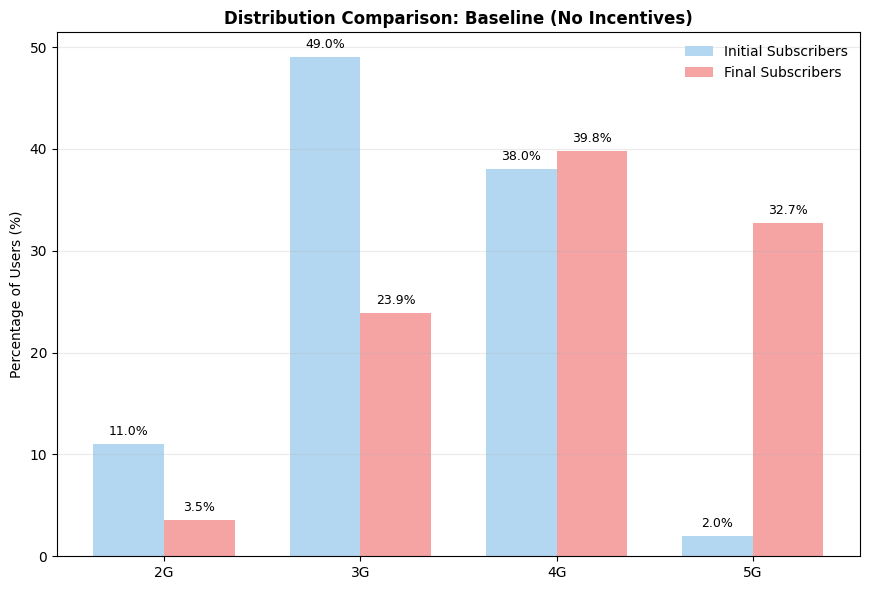

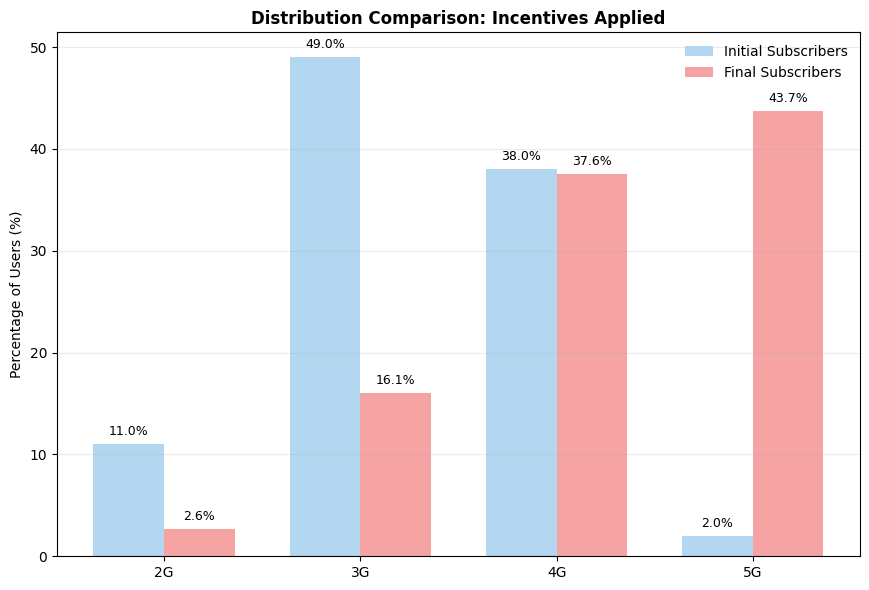

In [21]:
# Run the main simulation and create distribution comparison charts
print("Starting simulation...")
simulator = run_simulation(num_users=100_000)

# Create distribution comparison charts 
simulator.create_distribution_comparison_charts()

------------------------------------------------------------------------------------------------------------------------------------------

## 3. Plot Migration Flow Heatmaps

This cell creates **row-normalized heatmaps** showing user movement between network generations:
- Baseline ( No Incentives )
- Incentive ( With Incentives )

Reveals detailed migration paths and highlights upgrade bottlenecks.


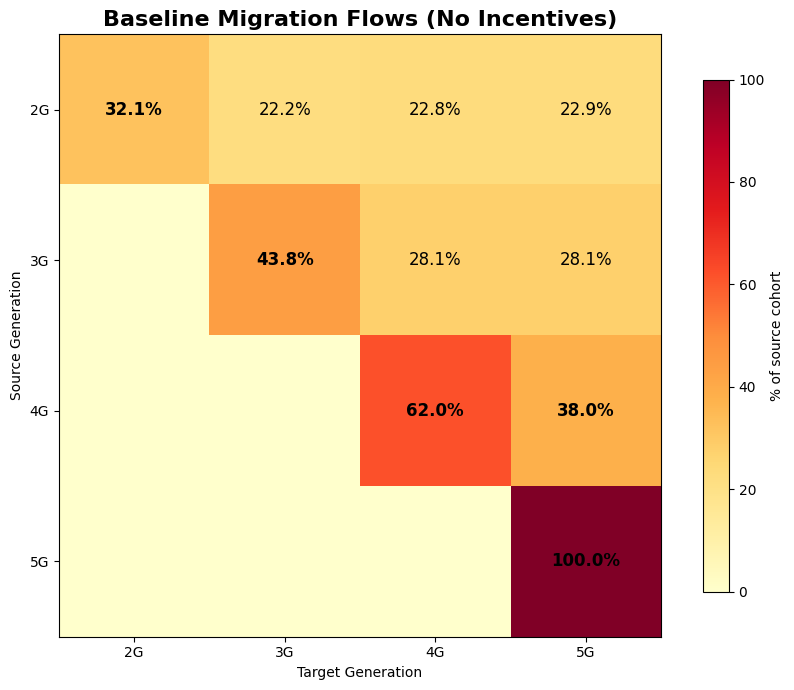

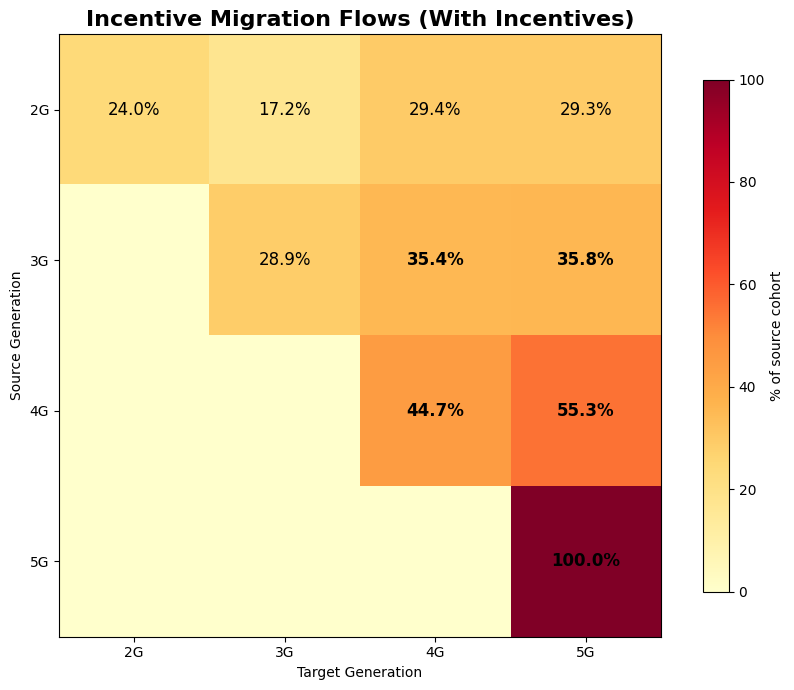

In [16]:
# Create migration flow heatmaps 
simulator.create_migration_flow_heatmaps(normalize='row')

------------------------------------------------------------------------------------------------------------------------------------------

## 4. Visualize Overall Migration Rate 

This cell produces **two charts** comparing overall migration rates between the Baseline and Incentive scenarios (eligible users; 5G starters excluded).

Offers a clean visual snapshot of overall migration improvement.


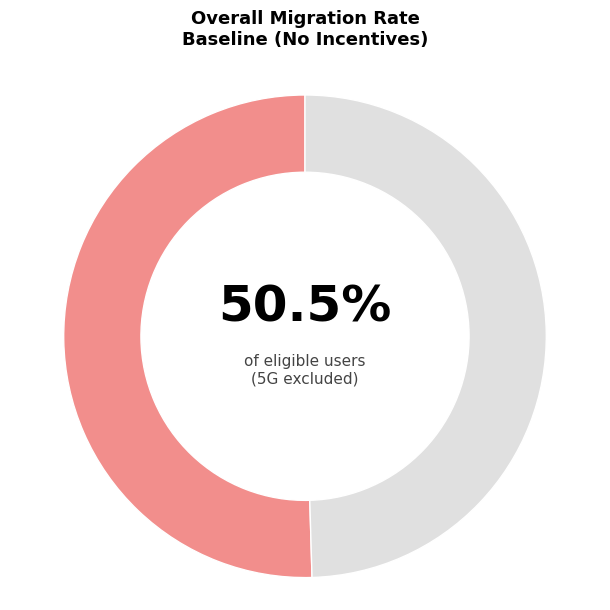

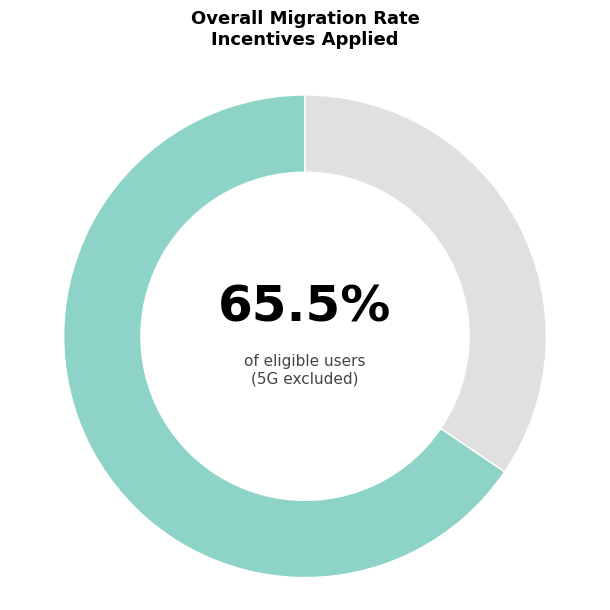

In [17]:
# Create donut charts for overall migration rates
simulator.create_single_migration_rate_card("baseline",  color="#F28E8C")
simulator.create_single_migration_rate_card("treatment", color="#8DD3C7")

------------------------------------------------------------------------------------------------------------------------------------------

## 5. Evaluate Individual Incentive Effectiveness

This cell isolates each incentive type to measure its independent effect on migration. It runs three simulations, each activating only one incentive at a time and presents the results.

Enables direct comparison of how strongly each incentive influences user migration behavior.



--- Running Treatment Simulation (With Incentives) ---

=== TREATMENT RESULTS ===
Overall Migration Rate (excl. 5G): 62.4%

Final Distribution:
  2G: 793 users (0.8%)
  3G: 7,351 users (7.4%)
  4G: 27,332 users (27.3%)
  5G: 64,524 users (64.5%)

Migration Flows:
  2G -> 3G: 600 users (0.60%)
  2G -> 4G: 1,070 users (1.07%)
  2G -> 5G: 1,066 users (1.07%)
  3G -> 4G: 8,506 users (8.51%)
  3G -> 5G: 8,651 users (8.65%)
  4G -> 5G: 22,060 users (22.06%)

--- Running Treatment Simulation (With Incentives) ---

=== TREATMENT RESULTS ===
Overall Migration Rate (excl. 5G): 56.5%

Final Distribution:
  2G: 948 users (0.9%)
  3G: 9,155 users (9.2%)
  4G: 27,403 users (27.4%)
  5G: 62,494 users (62.5%)

Migration Flows:
  2G -> 3G: 663 users (0.66%)
  2G -> 4G: 851 users (0.85%)
  2G -> 5G: 1,067 users (1.07%)
  3G -> 4G: 6,736 users (6.74%)
  3G -> 5G: 8,680 users (8.68%)
  4G -> 5G: 20,000 users (20.00%)

--- Running Treatment Simulation (With Incentives) ---

=== TREATMENT RESULTS ===
Overa

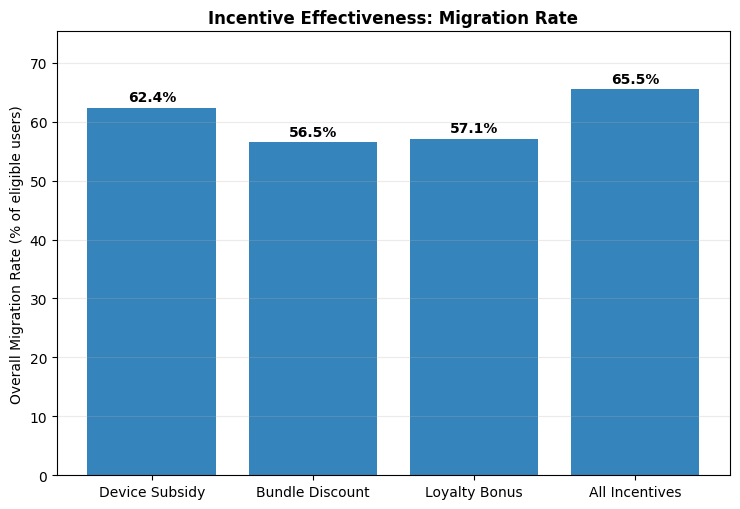

In [18]:
# Incentive effectiveness analysis (device-only, bundle-only, loyalty-only, and all incentives)
base_users_for_tests = simulator.users_baseline
env_ref = simulator.env

device_only_rate = run_one_incentive(
    sim_seed=1001,
    base_users=base_users_for_tests,
    env=env_ref,
    incentive_type='device',
    device_subsidies={'4G': 500, '5G': 1000}
)
bundle_only_rate = run_one_incentive(
    sim_seed=1002,
    base_users=base_users_for_tests,
    env=env_ref,
    incentive_type='bundle',
    bundle_discounts={'4G': 50, '5G': 150}
)
loyalty_only_rate = run_one_incentive(
    sim_seed=1003,
    base_users=base_users_for_tests,
    env=env_ref,
    incentive_type='loyalty',
    loyalty_bonuses={'5G': 200}
)
all_incentives_rate = float(simulator.treatment_results['migration_rate'])

rates_dict = {
    'Device Subsidy': device_only_rate,
    'Bundle Discount': bundle_only_rate,
    'Loyalty Bonus':  loyalty_only_rate,
    'All Incentives': all_incentives_rate
}
plot_incentive_effectiveness_bar(rates_dict)